In [59]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
from transformers import pipeline
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
from torch.utils.data import DataLoader
import os
import gc
gc.collect()

def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [60]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


In [61]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load('Product_Data_SQuAD_model.pt'))
model.eval()
nlp = pipeline("feature-extraction", model=model.to('cpu'), tokenizer=tokenizer)
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

21

In [62]:
train_df = pd.read_csv('Train_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward','label_for_train'],axis=1)
train_df = train_df.dropna(axis=0)
display(train_df.head(3))

val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward'],axis=1)
val_df = val_df.dropna(axis=0)
display(val_df.head(3))

,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
586,"YUNGSOX 2100M 12MT USD1,015/MT USD12,180 YUNGS...",0,13,YUNGSOX 2100M,855
92,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",0,50,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",140
91,"TRIS . CIF PORT KLANG,MALAYSIA",0,4,TRIS,139


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
1,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,1
2,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,2
3,PP 3307UNC1 . TRADE TERMS: CFR ANY JAPANESE PORT,0,2,PP,10


In [63]:
def find_fail_sample(df):
    fails = []
    for i in df.index:
        context = df.loc[i,'string_X_train']
        answer = df.loc[i,'Y_label']
        if answer not in context:
            fails.append(i)
    return fails
train_fails = find_fail_sample(train_df)
val_fails = find_fail_sample(val_df)
print(train_fails,val_fails)
display(val_df.loc[val_fails])
print(val_df.shape)
val_df = val_df.drop(val_fails,axis=0)
print(val_df.shape)

[] [342, 343, 344]


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
342,#NAME?,1,26,PURIFIED ISOPHTHALIC ACID,1238
343,#NAME?,1,26,PURIFIED ISOPHTHALIC ACID,1240
344,#NAME?,40,65,PURIFIED ISOPHTHALIC ACID,1241


(744, 5)
(741, 5)


In [74]:
max_test = max([max(train_df['string_X_train'].values,key=len),max(val_df['string_X_train'].values,key=len)],key=len)
max_test

". PHTHALIC ANHYDRIDE 1044MT AT USD 630/MT. PACKED IN JUMBO BAGS AND PALLETIZED. CIF DAMMAM SEAPORT, SAUDI ARABIA :46A:. 1. MANUALLY SIGNED COMMERCIAL INVOICES IN TWO ORIGINALS PLUS TWO COPIES, THE ORIGINAL MUST BE CERTIFIED BY CHAMBER OF COMMERCE. 2. CERTIFICATE OF ORIGIN ISSUED BY CHAMBER OF COMMERCE IN TWO ORIGINALS PLUS TWO COPIES STATING THE COUNTRY OF ORIGIN, NAME AND FULL ADDRESS OF THE MANUFACTURER/PRODUCER AND SHIPPER. 3. FULL SET OF SHIPPED ON BOARD BILL OF LADING ISSUED TO THE ORDER OF BANQUE SAUDI FRANSI-AL KHOBAR, MARKED FREIGHT PREPAID AND NOTIFY APPLICANT, SHOWING THE FOLLOWING: A THE NAME, FULL ADDRESS AND TELEPHONE NUMBER OF SHIPPING AGENT AT THE PORT OF DISCHARGE. B THE AGE OF THE VESSEL AND ITS YEAR OF BUILT. 4. A CERTIFICATE ISSUED AND SIGNED BY THE OWNER, AGENT, CAPTAIN OR COMPANY OF THE VESSEL APPENDED TO THE BILL OF LADING STATING: 1 NAME OF VESSEL ..... PREVIOUS NAME....... 2 NATIONALITY OF VESSEL ................... 3 OWNER OF VESSEL ......................... 4

In [95]:
train_emb = train_df['string_X_train'].head(100).tolist()
train_emb.append(max_test)
val_emb = val_df['string_X_train'].head(100).tolist()
val_emb.append(max_test)
train_emb = nlp(train_emb, padding="longest", truncation=True, max_length=40)
val_emb = nlp(val_emb, padding="longest", truncation=True, max_length=40)

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_emb)

PCA(n_components=2)

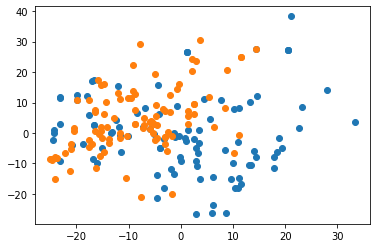

In [97]:
plt.scatter(pca.transform(train_emb)[:,0],pca.transform(train_emb)[:,1])
plt.scatter(pca.transform(val_emb)[:,0],pca.transform(val_emb)[:,1])

In [103]:
val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward'],axis=1)
val_df = val_df.dropna(axis=0)
display(val_df.head(10))

,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
1,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,1
2,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,2
3,PP 3307UNC1 . TRADE TERMS: CFR ANY JAPANESE PORT,0,2,PP,10
4,"CIF BELAWAN PORT, INDONESIA +20 MT +/- 5PCT OF...",47,62,2-ETHYL HEXANOL,13
5,"CIF BELAWAN PORT, INDONESIA +20 MTON +/-5PCT O...",48,63,2-ETHYL HEXANOL,14
6,TAISOX EVA 7470MQUANTITY:160.00MTUNIT PRICE:US...,0,16,TAISOX EVA 7470M,16
7,TAISOX EVA 7350MQUANTITY:90.00MTUNIT PRICE:USD...,0,16,TAISOX EVA 7350M,17
8,TAISOX EVA 7320MQUANTITY:30.00MTUNIT PRICE:USD...,0,16,TAISOX EVA 7320M,19
9,COVERING SHIPMENT OF GOODS TAISOX EVA 7350MQUA...,27,43,TAISOX EVA 7350M,25
10,TAISOX EVA 7350MQUANTITY:75.00MTUNIT PRICE:USD...,150,166,TAISOX EVA 7470M,30


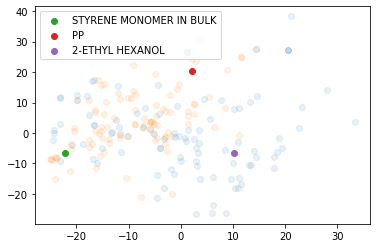

In [108]:
plt.scatter(pca.transform(train_emb)[:,0],pca.transform(train_emb)[:,1],alpha=0.1)
plt.scatter(pca.transform(val_emb)[:,0],pca.transform(val_emb)[:,1],alpha=0.1)
plt.scatter(pca.transform(val_emb)[0,0],pca.transform(val_emb)[0,1],label='STYRENE MONOMER IN BULK')
plt.scatter(pca.transform(val_emb)[2,0],pca.transform(val_emb)[2,1],label='PP')
plt.scatter(pca.transform(val_emb)[3,0],pca.transform(val_emb)[3,1],label='2-ETHYL HEXANOL')
plt.legend()
plt.show()